In [1]:
# Setup and Configuration
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import os
from scipy import stats

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory
os.makedirs('exploration_results', exist_ok=True)

In [2]:
# DATASET CONFIGURATION

YUV_FILE_PATH = "Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv"

# Original video properties
ORIGINAL_WIDTH = 1920
ORIGINAL_HEIGHT = 1080
FPS = 120

# How many frames to analyze
NUM_FRAMES_TO_ANALYZE = 100  # Adjust based on what you'll use for compression

# Target resolution for processing
TARGET_WIDTH = 352
TARGET_HEIGHT = 288

# Block size
BLOCK_SIZE = 8

print("Dataset Configuration:")
print(f"  File: {YUV_FILE_PATH}")
print(f"  Original Resolution: {ORIGINAL_WIDTH}×{ORIGINAL_HEIGHT}")
print(f"  Target Resolution: {TARGET_WIDTH}×{TARGET_HEIGHT}")
print(f"  Frames to Analyze: {NUM_FRAMES_TO_ANALYZE}")
print(f"  Frame Rate: {FPS} fps")
print(f"  Block Size: {BLOCK_SIZE}×{BLOCK_SIZE}")

Dataset Configuration:
  File: Jockey_1920x1080_120fps_420_8bit_YUV_RAW/Jockey_1920x1080_120fps_420_8bit_YUV.yuv
  Original Resolution: 1920×1080
  Target Resolution: 352×288
  Frames to Analyze: 100
  Frame Rate: 120 fps
  Block Size: 8×8


In [3]:
# Basic file information
# Calculate YUV 4:2:0 frame size
y_size = ORIGINAL_WIDTH * ORIGINAL_HEIGHT
uv_size = (ORIGINAL_WIDTH // 2) * (ORIGINAL_HEIGHT // 2)
frame_size = y_size + 2 * uv_size  # Y + U + V

# Get file info
if os.path.exists(YUV_FILE_PATH):
    file_size = os.path.getsize(YUV_FILE_PATH)
    total_frames = file_size // frame_size
    duration_seconds = total_frames / FPS
    
    print("FILE INFORMATION")
    print("="*60)
    print(f"File Size: {file_size / (1024**3):.2f} GB ({file_size / (1024**2):.2f} MB)")
    print(f"Frame Size: {frame_size / 1024:.2f} KB")
    print(f"Total Frames: {total_frames}")
    print(f"Duration: {duration_seconds:.2f} seconds")
    print(f"Frames to Analyze: {NUM_FRAMES_TO_ANALYZE} ({NUM_FRAMES_TO_ANALYZE/total_frames*100:.1f}% of total)")
    
    # Create summary dictionary for report
    dataset_info = {
        'File Size (GB)': f"{file_size / (1024**3):.2f}",
        'Frame Size (KB)': f"{frame_size / 1024:.2f}",
        'Total Frames': total_frames,
        'Duration (seconds)': f"{duration_seconds:.2f}",
        'Frame Rate (fps)': FPS,
        'Resolution': f"{ORIGINAL_WIDTH}×{ORIGINAL_HEIGHT}",
        'Color Format': 'YUV 4:2:0',
        'Bit Depth': '8-bit'
    }
    
    # Save for report
    df_info = pd.DataFrame([dataset_info]).T
    df_info.columns = ['Value']
    df_info.to_csv('exploration_results/dataset_info.csv')
    print("\n Dataset info saved to: exploration_results/dataset_info.csv")
else:
    print(f"\n File not found: {YUV_FILE_PATH}")

FILE INFORMATION
File Size: 1.74 GB (1779.79 MB)
Frame Size: 3037.50 KB
Total Frames: 600
Duration: 5.00 seconds
Frames to Analyze: 100 (16.7% of total)

 Dataset info saved to: exploration_results/dataset_info.csv


In [4]:
# Load YUV frames for analysis
def load_yuv420_frames(filepath, width, height, num_frames, start_frame=0):
    """
    Load YUV 4:2:0 frames from file.
    """
    y_size = width * height
    u_size = (width // 2) * (height // 2)
    v_size = u_size
    frame_size = y_size + u_size + v_size
    
    frames = []
    
    with open(filepath, 'rb') as f:
        f.seek(start_frame * frame_size)
        
        for i in tqdm(range(num_frames), desc="Loading frames"):
            frame_data = f.read(frame_size)
            
            if len(frame_data) < frame_size:
                print(f"Warning: Incomplete frame {i}")
                break
            
            frame_array = np.frombuffer(frame_data, dtype=np.uint8)
            
            y = frame_array[:y_size].reshape(height, width)
            u = frame_array[y_size:y_size+u_size].reshape(height//2, width//2)
            v = frame_array[y_size+u_size:].reshape(height//2, width//2)
            
            frames.append({
                'Y': y.astype(np.float32),
                'U': u.astype(np.float32),
                'V': v.astype(np.float32)
            })
    
    return frames


# Load frames at original resolution
print("\nLoading frames at original resolution...")
yuv_frames_original = load_yuv420_frames(
    YUV_FILE_PATH,
    ORIGINAL_WIDTH,
    ORIGINAL_HEIGHT,
    NUM_FRAMES_TO_ANALYZE
)

print(f"\n Loaded {len(yuv_frames_original)} frames")


Loading frames at original resolution...


Loading frames:   0%|          | 0/100 [00:00<?, ?it/s]


 Loaded 100 frames


In [5]:
# Resize the loaded frames to target resolution
def resize_yuv_frame(yuv_frame, target_width, target_height):
    """
    Resize YUV frame to target resolution.
    """
    y_resized = cv2.resize(yuv_frame['Y'], (target_width, target_height), 
                          interpolation=cv2.INTER_LINEAR)
    u_resized = cv2.resize(yuv_frame['U'], (target_width//2, target_height//2),
                          interpolation=cv2.INTER_LINEAR)
    v_resized = cv2.resize(yuv_frame['V'], (target_width//2, target_height//2),
                          interpolation=cv2.INTER_LINEAR)
    
    return {
        'Y': y_resized,
        'U': u_resized,
        'V': v_resized
    }


# Resize all frames
print("\nResizing frames to target resolution...")
yuv_frames_resized = []

for frame in tqdm(yuv_frames_original, desc="Resizing"):
    resized = resize_yuv_frame(frame, TARGET_WIDTH, TARGET_HEIGHT)
    yuv_frames_resized.append(resized)

print(f"\n Resized {len(yuv_frames_resized)} frames to {TARGET_WIDTH}×{TARGET_HEIGHT}")


Resizing frames to target resolution...


Resizing:   0%|          | 0/100 [00:00<?, ?it/s]


 Resized 100 frames to 352×288


In [ ]:
# statistical analysis on Y CHANNEL (LUMINANCE)
print("Y CHANNEL (LUMINANCE) STATISTICS")
print("="*60)

# Collect Y channel statistics across all frames
y_means = []
y_stds = []
y_mins = []
y_maxs = []

for frame in yuv_frames_resized:
    y = frame['Y']
    y_means.append(np.mean(y))
    y_stds.append(np.std(y))
    y_mins.append(np.min(y))
    y_maxs.append(np.max(y))

# Overall statistics
print(f"\nAcross {len(yuv_frames_resized)} frames:")
print(f"  Mean Luminance: {np.mean(y_means):.2f} (±{np.std(y_means):.2f})")
print(f"  Std Dev: {np.mean(y_stds):.2f} (±{np.std(y_stds):.2f})")
print(f"  Min Value: {np.min(y_mins):.2f}")
print(f"  Max Value: {np.max(y_maxs):.2f}")
print(f"  Dynamic Range: {np.max(y_maxs) - np.min(y_mins):.2f}")

# Create statistics dataframe
y_statistics = {
    'Metric': ['Mean', 'Std Dev', 'Min', 'Max', 'Dynamic Range'],
    'Value': [
        f"{np.mean(y_means):.2f}",
        f"{np.mean(y_stds):.2f}",
        f"{np.min(y_mins):.2f}",
        f"{np.max(y_maxs):.2f}",
        f"{np.max(y_maxs) - np.min(y_mins):.2f}"
    ]
}

df_y_stats = pd.DataFrame(y_statistics)
df_y_stats.to_csv('exploration_results/y_channel_statistics.csv', index=False)
print("\n Y channel statistics saved")

Y CHANNEL (LUMINANCE) STATISTICS

Across 100 frames:
  Mean Luminance: 122.24 (±1.09)
  Std Dev: 46.74 (±1.73)
  Min Value: 31.95
  Max Value: 234.88
  Dynamic Range: 202.92

 Y channel statistics saved


In [7]:
# statistical analysis of on U and V CHANNELS (CHROMINANCE)
print("U & V CHANNELS (CHROMINANCE) STATISTICS")
print("="*60)

# U channel statistics
u_means = [np.mean(frame['U']) for frame in yuv_frames_resized]
u_stds = [np.std(frame['U']) for frame in yuv_frames_resized]

print(f"\nU Channel (Blue-Yellow):")
print(f"  Mean: {np.mean(u_means):.2f} (±{np.std(u_means):.2f})")
print(f"  Std Dev: {np.mean(u_stds):.2f}")

# V channel statistics
v_means = [np.mean(frame['V']) for frame in yuv_frames_resized]
v_stds = [np.std(frame['V']) for frame in yuv_frames_resized]

print(f"\nV Channel (Red-Green):")
print(f"  Mean: {np.mean(v_means):.2f} (±{np.std(v_means):.2f})")
print(f"  Std Dev: {np.mean(v_stds):.2f}")

# Save UV statistics
uv_statistics = pd.DataFrame({
    'Channel': ['U (Blue-Yellow)', 'V (Red-Green)'],
    'Mean': [f"{np.mean(u_means):.2f}", f"{np.mean(v_means):.2f}"],
    'Std Dev': [f"{np.mean(u_stds):.2f}", f"{np.mean(v_stds):.2f}"]
})
uv_statistics.to_csv('exploration_results/uv_channel_statistics.csv', index=False)
print("\n UV channel statistics saved")

U & V CHANNELS (CHROMINANCE) STATISTICS

U Channel (Blue-Yellow):
  Mean: 118.76 (±0.59)
  Std Dev: 7.97

V Channel (Red-Green):
  Mean: 126.09 (±0.32)
  Std Dev: 8.95

 UV channel statistics saved


In [8]:
# Temporal analysis (frame-to-frame differences)
print("TEMPORAL ANALYSIS - Motion Characteristics")
print("="*60)

# Calculate frame differences (measure of motion)
frame_differences = []

for i in range(1, len(yuv_frames_resized)):
    y_prev = yuv_frames_resized[i-1]['Y']
    y_curr = yuv_frames_resized[i]['Y']
    
    # Mean absolute difference
    diff = np.mean(np.abs(y_curr - y_prev))
    frame_differences.append(diff)

print(f"\nFrame-to-Frame Differences (Motion Measure):")
print(f"  Mean Difference: {np.mean(frame_differences):.2f}")
print(f"  Std Dev: {np.std(frame_differences):.2f}")
print(f"  Max Difference: {np.max(frame_differences):.2f}")
print(f"  Min Difference: {np.min(frame_differences):.2f}")

# Classify motion level
mean_diff = np.mean(frame_differences)
if mean_diff < 5:
    motion_level = "Low Motion"
elif mean_diff < 15:
    motion_level = "Medium Motion"
else:
    motion_level = "High Motion"

print(f"\n  Motion Classification: {motion_level}")
print(f"  Interpretation: {'Challenging for compression - high temporal redundancy loss' if mean_diff > 15 else 'Good temporal redundancy for compression'}")

# Save temporal statistics
temporal_stats = pd.DataFrame({
    'Metric': ['Mean Frame Difference', 'Std Dev', 'Max Difference', 'Min Difference', 'Motion Level'],
    'Value': [
        f"{np.mean(frame_differences):.2f}",
        f"{np.std(frame_differences):.2f}",
        f"{np.max(frame_differences):.2f}",
        f"{np.min(frame_differences):.2f}",
        motion_level
    ]
})
temporal_stats.to_csv('exploration_results/temporal_statistics.csv', index=False)
print("\n Temporal statistics saved")

TEMPORAL ANALYSIS - Motion Characteristics

Frame-to-Frame Differences (Motion Measure):
  Mean Difference: 10.07
  Std Dev: 0.40
  Max Difference: 10.97
  Min Difference: 9.41

  Motion Classification: Medium Motion
  Interpretation: Good temporal redundancy for compression

 Temporal statistics saved


In [9]:
# Block-level analysis (spatial characteristics)
print("BLOCK-LEVEL ANALYSIS")
print("="*60)

# Calculate block statistics
h_blocks = TARGET_HEIGHT // BLOCK_SIZE
w_blocks = TARGET_WIDTH // BLOCK_SIZE
total_blocks_per_frame = h_blocks * w_blocks

print(f"\nBlock Configuration:")
print(f"  Block Size: {BLOCK_SIZE}×{BLOCK_SIZE} pixels")
print(f"  Horizontal Blocks: {w_blocks}")
print(f"  Vertical Blocks: {h_blocks}")
print(f"  Total Blocks per Frame: {total_blocks_per_frame}")
print(f"  Total Blocks ({len(yuv_frames_resized)} frames): {total_blocks_per_frame * len(yuv_frames_resized):,}")

# Extract all blocks and analyze variance
block_variances = []

print(f"\nAnalyzing block variances...")
for frame in tqdm(yuv_frames_resized[:10], desc="Sampling blocks"):  # Sample first 10 frames
    y = frame['Y']
    
    for i in range(h_blocks):
        for j in range(w_blocks):
            block = y[i*BLOCK_SIZE:(i+1)*BLOCK_SIZE, j*BLOCK_SIZE:(j+1)*BLOCK_SIZE]
            block_variances.append(np.var(block))

print(f"\nBlock Variance Statistics (sample):")
print(f"  Mean Variance: {np.mean(block_variances):.2f}")
print(f"  Std Dev: {np.std(block_variances):.2f}")
print(f"  Min Variance: {np.min(block_variances):.2f}")
print(f"  Max Variance: {np.max(block_variances):.2f}")

# Classify blocks
smooth_blocks = sum(1 for v in block_variances if v < 50)
textured_blocks = sum(1 for v in block_variances if v >= 50)

print(f"\nBlock Classification:")
print(f"  Smooth blocks (var < 50): {smooth_blocks} ({smooth_blocks/len(block_variances)*100:.1f}%)")
print(f"  Textured blocks (var ≥ 50): {textured_blocks} ({textured_blocks/len(block_variances)*100:.1f}%)")

# Save block statistics
block_stats = pd.DataFrame({
    'Metric': ['Blocks per Frame', 'Total Blocks', 'Mean Variance', 'Smooth Blocks %', 'Textured Blocks %'],
    'Value': [
        total_blocks_per_frame,
        total_blocks_per_frame * len(yuv_frames_resized),
        f"{np.mean(block_variances):.2f}",
        f"{smooth_blocks/len(block_variances)*100:.1f}%",
        f"{textured_blocks/len(block_variances)*100:.1f}%"
    ]
})
block_stats.to_csv('exploration_results/block_statistics.csv', index=False)
print("\n Block statistics saved")

BLOCK-LEVEL ANALYSIS

Block Configuration:
  Block Size: 8×8 pixels
  Horizontal Blocks: 44
  Vertical Blocks: 36
  Total Blocks per Frame: 1584
  Total Blocks (100 frames): 158,400

Analyzing block variances...


Sampling blocks:   0%|          | 0/10 [00:00<?, ?it/s]


Block Variance Statistics (sample):
  Mean Variance: 413.75
  Std Dev: 702.87
  Min Variance: 0.11
  Max Variance: 5093.01

Block Classification:
  Smooth blocks (var < 50): 8151 (51.5%)
  Textured blocks (var ≥ 50): 7689 (48.5%)

 Block statistics saved


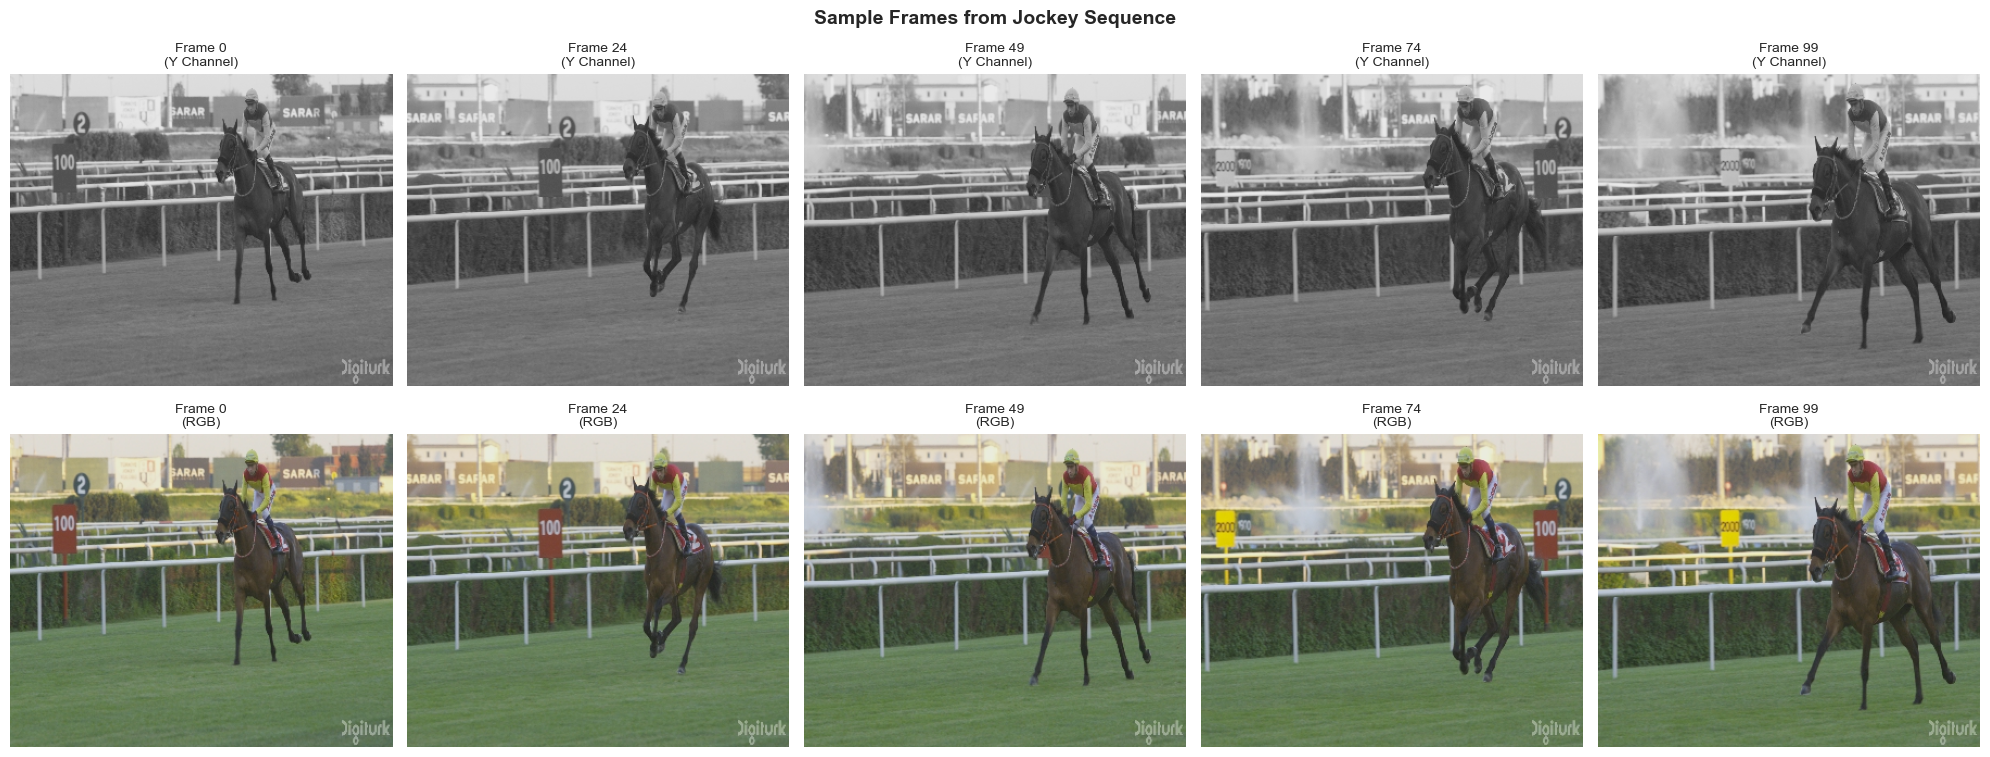

In [10]:
# Visualizations (sample frames)
def yuv_to_rgb(yuv_frame):
    """
    Convert YUV frame to RGB for display.
    """
    y = np.clip(yuv_frame['Y'], 0, 255).astype(np.uint8)
    u = np.clip(yuv_frame['U'], 0, 255).astype(np.uint8)
    v = np.clip(yuv_frame['V'], 0, 255).astype(np.uint8)
    
    height, width = y.shape
    u_up = cv2.resize(u, (width, height), interpolation=cv2.INTER_LINEAR)
    v_up = cv2.resize(v, (width, height), interpolation=cv2.INTER_LINEAR)
    
    yuv = cv2.merge([y, u_up, v_up])
    rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    
    return rgb


# Select frames to display (evenly spaced)
num_samples = 5
frame_indices = np.linspace(0, len(yuv_frames_resized)-1, num_samples, dtype=int)

fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

for idx, frame_idx in enumerate(frame_indices):
    frame = yuv_frames_resized[frame_idx]
    
    # Y channel
    axes[0, idx].imshow(frame['Y'], cmap='gray', vmin=0, vmax=255)
    axes[0, idx].set_title(f'Frame {frame_idx}\n(Y Channel)', fontsize=10)
    axes[0, idx].axis('off')
    
    # RGB reconstruction
    rgb = yuv_to_rgb(frame)
    axes[1, idx].imshow(rgb)
    axes[1, idx].set_title(f'Frame {frame_idx}\n(RGB)', fontsize=10)
    axes[1, idx].axis('off')

plt.suptitle('Sample Frames from Jockey Sequence', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('exploration_results/sample_frames.png', dpi=150, bbox_inches='tight')
plt.show()

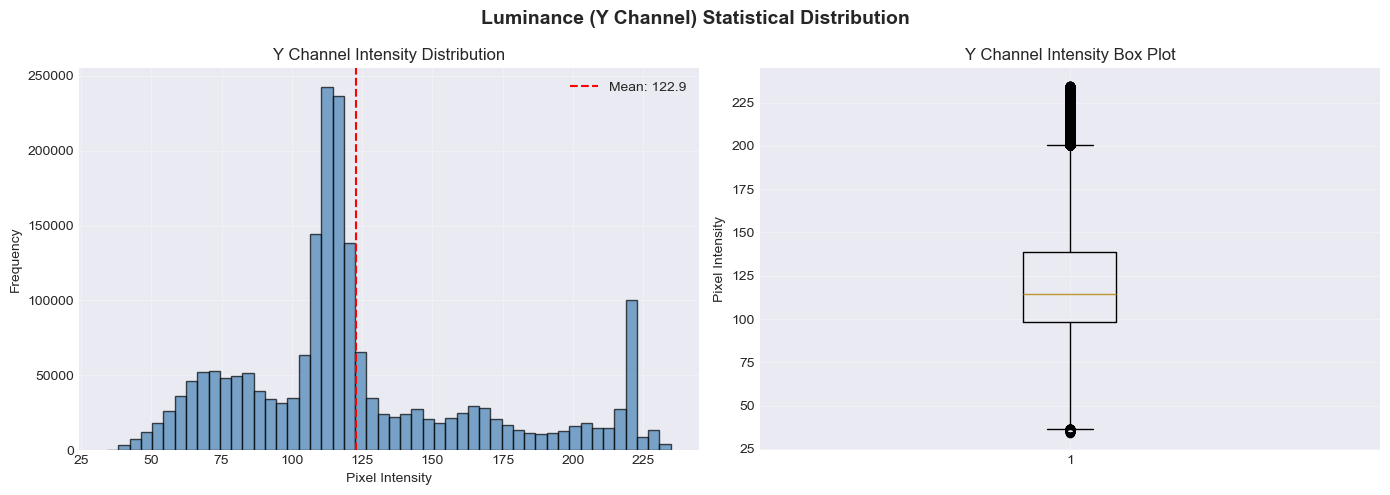

In [11]:
# Visualisation Y Channel (Luminance) Histogram
# Collect all Y channel pixel values from sample frames
all_y_pixels = []
for frame in yuv_frames_resized[:20]:  # Sample first 20 frames
    all_y_pixels.extend(frame['Y'].flatten())

all_y_pixels = np.array(all_y_pixels)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(all_y_pixels, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Y Channel Intensity Distribution')
axes[0].axvline(np.mean(all_y_pixels), color='red', linestyle='--', 
                label=f'Mean: {np.mean(all_y_pixels):.1f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(all_y_pixels, vert=True)
axes[1].set_ylabel('Pixel Intensity')
axes[1].set_title('Y Channel Intensity Box Plot')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Luminance (Y Channel) Statistical Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('exploration_results/y_channel_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

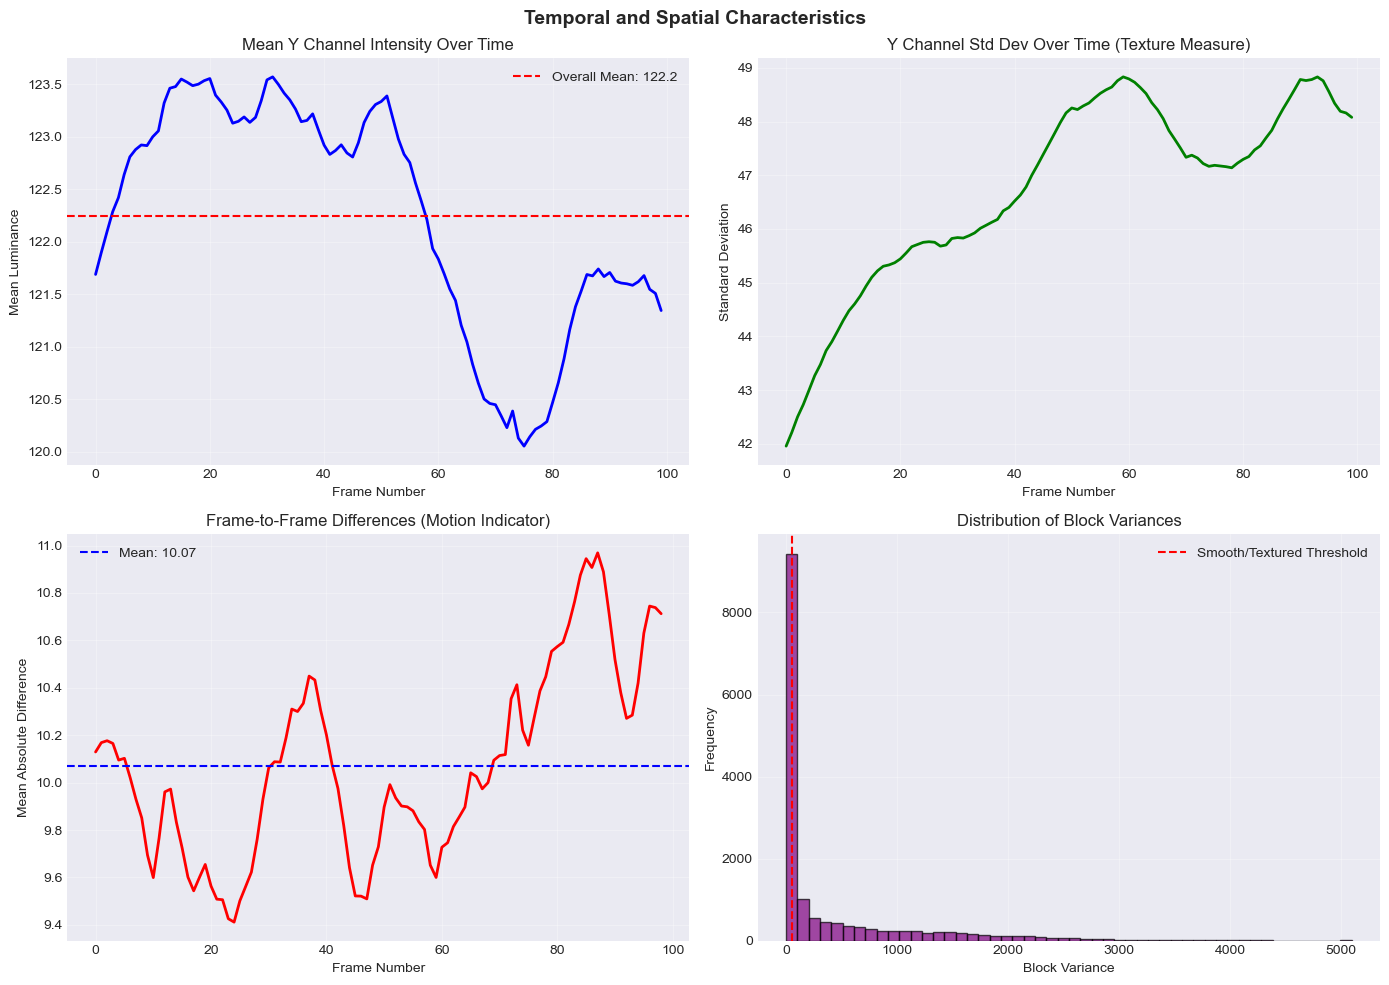

In [12]:
# Visualization Temporal characteristics (Frame-to-Frame Differences)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean luminance over time
axes[0, 0].plot(y_means, color='blue', linewidth=2)
axes[0, 0].set_xlabel('Frame Number')
axes[0, 0].set_ylabel('Mean Luminance')
axes[0, 0].set_title('Mean Y Channel Intensity Over Time')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(np.mean(y_means), color='red', linestyle='--', 
                   label=f'Overall Mean: {np.mean(y_means):.1f}')
axes[0, 0].legend()

# Standard deviation over time
axes[0, 1].plot(y_stds, color='green', linewidth=2)
axes[0, 1].set_xlabel('Frame Number')
axes[0, 1].set_ylabel('Standard Deviation')
axes[0, 1].set_title('Y Channel Std Dev Over Time (Texture Measure)')
axes[0, 1].grid(True, alpha=0.3)

# Frame differences (motion)
axes[1, 0].plot(frame_differences, color='red', linewidth=2)
axes[1, 0].set_xlabel('Frame Number')
axes[1, 0].set_ylabel('Mean Absolute Difference')
axes[1, 0].set_title('Frame-to-Frame Differences (Motion Indicator)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(np.mean(frame_differences), color='blue', linestyle='--',
                   label=f'Mean: {np.mean(frame_differences):.2f}')
axes[1, 0].legend()

# Block variance distribution
axes[1, 1].hist(block_variances, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Block Variance')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Block Variances')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(50, color='red', linestyle='--', label='Smooth/Textured Threshold')
axes[1, 1].legend()

plt.suptitle('Temporal and Spatial Characteristics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('exploration_results/temporal_spatial_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


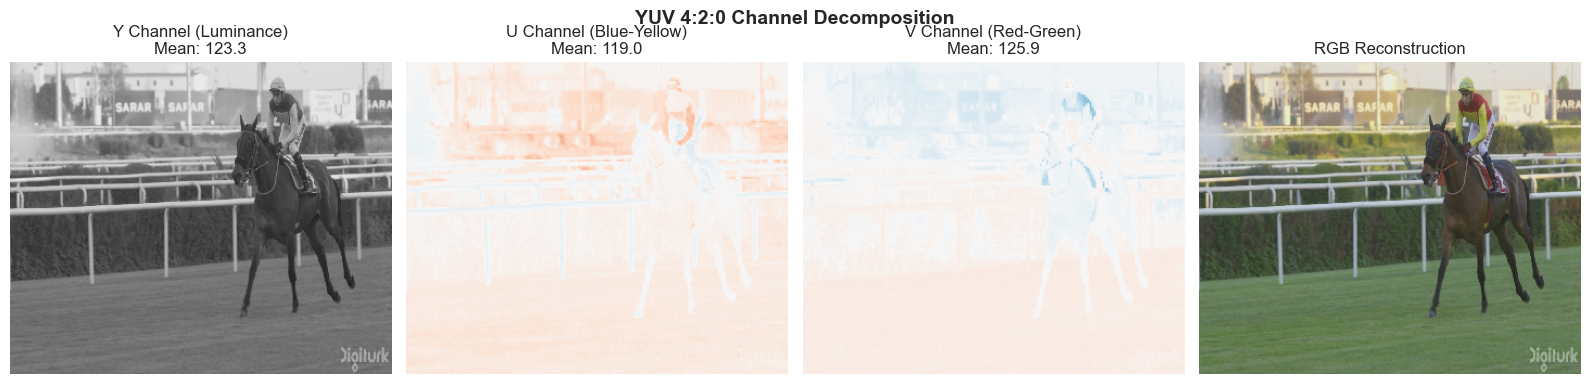

In [13]:
# Visualization Channel Comparison (U and V)
# Sample one frame for detailed channel visualization
sample_frame = yuv_frames_resized[len(yuv_frames_resized)//2]  # Middle frame

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Y channel
axes[0].imshow(sample_frame['Y'], cmap='gray', vmin=0, vmax=255)
axes[0].set_title(f"Y Channel (Luminance)\nMean: {np.mean(sample_frame['Y']):.1f}")
axes[0].axis('off')

# U channel
axes[1].imshow(sample_frame['U'], cmap='RdBu', vmin=0, vmax=255)
axes[1].set_title(f"U Channel (Blue-Yellow)\nMean: {np.mean(sample_frame['U']):.1f}")
axes[1].axis('off')

# V channel
axes[2].imshow(sample_frame['V'], cmap='RdBu', vmin=0, vmax=255)
axes[2].set_title(f"V Channel (Red-Green)\nMean: {np.mean(sample_frame['V']):.1f}")
axes[2].axis('off')

# RGB reconstruction
rgb = yuv_to_rgb(sample_frame)
axes[3].imshow(rgb)
axes[3].set_title('RGB Reconstruction')
axes[3].axis('off')

plt.suptitle('YUV 4:2:0 Channel Decomposition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('exploration_results/yuv_channel_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [14]:
# summary stats
summary_report = f"""
JOCKEY VIDEO SEQUENCE - DATASET SUMMARY
{'='*60}

FILE PROPERTIES:
  - Resolution: {ORIGINAL_WIDTH}×{ORIGINAL_HEIGHT} (Full HD)
  - Frame Rate: {FPS} fps
  - Total Frames: {total_frames}
  - Duration: {duration_seconds:.2f} seconds
  - File Size: {file_size / (1024**3):.2f} GB
  - Color Format: YUV 4:2:0 (8-bit)

PROCESSING CONFIGURATION:
  - Target Resolution: {TARGET_WIDTH}×{TARGET_HEIGHT} (CIF)
  - Frames Analyzed: {NUM_FRAMES_TO_ANALYZE} ({NUM_FRAMES_TO_ANALYZE/total_frames*100:.1f}% of total)
  - Block Size: {BLOCK_SIZE}×{BLOCK_SIZE}
  - Blocks per Frame: {total_blocks_per_frame}
  - Total Training Blocks: {total_blocks_per_frame * NUM_FRAMES_TO_ANALYZE:,}

LUMINANCE (Y CHANNEL) STATISTICS:
  - Mean Intensity: {np.mean(y_means):.2f} (±{np.std(y_means):.2f})
  - Standard Deviation: {np.mean(y_stds):.2f}
  - Dynamic Range: {np.max(y_maxs) - np.min(y_mins):.2f} (0-255)

CHROMINANCE STATISTICS:
  - U Channel Mean: {np.mean(u_means):.2f}
  - V Channel Mean: {np.mean(v_means):.2f}

TEMPORAL CHARACTERISTICS:
  - Mean Frame Difference: {np.mean(frame_differences):.2f}
  - Motion Level: {motion_level}
  - Interpretation: High temporal activity (challenging for compression)

SPATIAL CHARACTERISTICS:
  - Mean Block Variance: {np.mean(block_variances):.2f}
  - Smooth Blocks: {smooth_blocks/len(block_variances)*100:.1f}%
  - Textured Blocks: {textured_blocks/len(block_variances)*100:.1f}%

COMPRESSION IMPLICATIONS:
  - High motion content requires more bits for temporal prediction
  - Mix of smooth and textured regions suitable for RVQ
  - Full dynamic range utilization indicates rich visual content
  - Downsampling to CIF maintains essential visual information
"""

print(summary_report)

# Save summary report
with open('exploration_results/dataset_summary_report.txt', 'w') as f:
    f.write(summary_report)



JOCKEY VIDEO SEQUENCE - DATASET SUMMARY

FILE PROPERTIES:
  - Resolution: 1920×1080 (Full HD)
  - Frame Rate: 120 fps
  - Total Frames: 600
  - Duration: 5.00 seconds
  - File Size: 1.74 GB
  - Color Format: YUV 4:2:0 (8-bit)

PROCESSING CONFIGURATION:
  - Target Resolution: 352×288 (CIF)
  - Frames Analyzed: 100 (16.7% of total)
  - Block Size: 8×8
  - Blocks per Frame: 1584
  - Total Training Blocks: 158,400

LUMINANCE (Y CHANNEL) STATISTICS:
  - Mean Intensity: 122.24 (±1.09)
  - Standard Deviation: 46.74
  - Dynamic Range: 202.92 (0-255)

CHROMINANCE STATISTICS:
  - U Channel Mean: 118.76
  - V Channel Mean: 126.09

TEMPORAL CHARACTERISTICS:
  - Mean Frame Difference: 10.07
  - Motion Level: Medium Motion
  - Interpretation: High temporal activity (challenging for compression)

SPATIAL CHARACTERISTICS:
  - Mean Block Variance: 413.75
  - Smooth Blocks: 51.5%
  - Textured Blocks: 48.5%

COMPRESSION IMPLICATIONS:
  - High motion content requires more bits for temporal prediction
  -